# Benchmark: Native PyTorch DL vs. NVTabular DL on Rossmann Sales Dataset

## Simple comparison

NVTabular data loader for PyTorch showed 10x-20x speedup in comparison to the native PyTorch data loader. This notebook addresses the question, **does the NVTabular data loader convergeces to the same performance as the native PyTorch data loader and in which umber of epochs?**<br><br>

In this notebook, we do a simple direct comparison between both approaches.<br><br>

We train the native PyTorch data loader for 750 epochs to establish a baseline 
We train the NVTabular data loader for PyTorch for 750 epochs
We compare train_loss, train_rmspe, valid_loss, valid_rmspe and computation time

**Summary:**
* NVTabular data loader has a **speed-up of 10x**, training in ~20min instead of 3.47h.
* NVTabular convergeces to the **same minimum of `valid RMSPE`** than the native PyTorch data loader.
* NVTabular's convergence per epoch is **similar** to the native PyTorch data loader.

**Content**:
1. [Train the data loaders](#train) <br>
1a. [Native PyTorch data loader](#trainpyt)<br>
1b. [NVTabular data loader for PyTorch](#trainnvt)
2. [**Analyse the convergence**](#plot)

### Training the data loaders
<a id="train"></a>

First, we train our data loaders. The code is based on the [Rossman Sales Example in the NVTabular github](../../rossmann-store-sales-example.ipynb) and uses the data from the [preprocessing script](../../rossmann-store-sales-preproc.ipynb).

In [1]:
import os
import time
import glob
import torch

import nvtabular as nvt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from nvtabular.loader.torch import TorchAsyncItr, DLDataLoader
from nvtabular.framework_utils.torch.models import Model
from nvtabular.framework_utils.torch.utils import process_epoch

/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_NVVM=/usr/local/cuda/nvvm/lib64/libnvvm.so.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))
/conda/envs/rapids/lib/python3.7/site-packages/numba/cuda/envvars.py:17: NumbaWarning: 
Environment variables with the 'NUMBAPRO' prefix are deprecated and consequently ignored, found use of NUMBAPRO_LIBDEVICE=/usr/local/cuda/nvvm/libdevice/.

For more information about alternatives visit: ('http://numba.pydata.org/numba-doc/latest/cuda/overview.html', '#cudatoolkit-lookup')
  warnings.warn(errors.NumbaWarning(msg))


In [2]:
def rmspe_func(y_pred, y):
    "Return y_pred and y to non-log space and compute RMSPE"
    y_pred, y = torch.exp(y_pred) - 1, torch.exp(y) - 1
    pct_var = (y_pred - y) / y
    return (pct_var**2).mean().pow(0.5)

class CustomDataset(Dataset):
  """Simple dataset class for dataloader"""
  def __init__(self, df, cats, conts, labels):
    """Initialize the CustomDataset"""
    self.cats = df[cats].astype(np.int64).values
    self.conts = df[conts].astype(np.float32).values
    self.labels = df[labels].astype(np.float32).values
  
  def __len__(self):
    """Return the total length of the dataset"""
    dataset_size = self.cats.shape[0]
    return dataset_size
  
  def __getitem__(self, idx):
    """Return the batch given the indices"""
    return self.cats[idx], self.conts[idx], self.labels[idx]

def process_epoch(dataloader, model, train=False, optimizer=None, loss_func=torch.nn.MSELoss(), pyt_dl=False):
    """
    The controlling function that loads data supplied via a dataloader to a model. Can be redefined
    based on parameters.
    Parameters
    -----------
    dataloader : iterator
        Iterator that contains the dataset to be submitted to the model.
    model : torch.nn.Module
        Pytorch model to run data through.
    train : bool
        Indicate whether dataloader contains training set.
    optimizer : object
        Optimizer to run in conjunction with model.
    loss_func : function
        Loss function to use, default is MSELoss.
    """
    model.train(mode=train)
    with torch.set_grad_enabled(train):
        y_list, y_pred_list = [], []
        for x_cat, x_cont, y in iter(dataloader):
            if pyt_dl:
                x_cat, x_cont, y = x_cat.cuda(), x_cont.cuda(), torch.squeeze(y).cuda()
            y_list.append(y.detach())
            y_pred = model(x_cat, x_cont)
            y_pred_list.append(y_pred.detach())
            loss = loss_func(y_pred, y)
            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    y = torch.cat(y_list)
    y_pred = torch.cat(y_pred_list)
    epoch_loss = loss_func(y_pred, y).item()
    return epoch_loss, y_pred, y

def run_benchmark(dl_train, dl_valid, pyt_dl=False):
    model = Model(
        embedding_table_shapes=EMBEDDING_TABLE_SHAPES,
        num_continuous=len(CONTINUOUS_COLUMNS),
        emb_dropout=EMBEDDING_DROPOUT_RATE,
        layer_hidden_dims=HIDDEN_DIMS,
        layer_dropout_rates=DROPOUT_RATES,
        max_output=MAX_LOG_SALES_PREDICTION
    ).to('cuda')

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    hist_dl = []
    time_start = time.time()
    for epoch in range(EPOCHS):
        train_loss, y_pred, y = process_epoch(dl_train, model, train=True, optimizer=optimizer, pyt_dl=pyt_dl)
        train_rmspe = rmspe_func(y_pred, y)
        valid_loss, y_pred, y = process_epoch(dl_valid, model, train=False, pyt_dl=pyt_dl)
        valid_rmspe = rmspe_func(y_pred, y)
        hist_dl.append({
            'epoch': epoch, 
            'train_loss': train_loss, 
            'train_rmspe': train_rmspe.item(), 
            'valid_loss': valid_loss, 
            'valid_rmspe': valid_rmspe.item()
        })
        print(f'Epoch {epoch:02d}. Train loss: {train_loss:.4f}. Train RMSPE: {train_rmspe:.4f}. Valid loss: {valid_loss:.4f}. Valid RMSPE: {valid_rmspe:.4f}.')

    time_end = time.time()
    return time_end-time_start, hist_dl

In [3]:
DATA_DIR = os.environ.get("OUTPUT_DATA_DIR", "../../data")

CATEGORICAL_COLUMNS = [
    'Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw'
]

CONTINUOUS_COLUMNS = [
    'CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday'
]
LABEL_COLUMNS = ['Sales']

COLUMNS = CATEGORICAL_COLUMNS + CONTINUOUS_COLUMNS + LABEL_COLUMNS

In [4]:
! ls $DATA_DIR

ross_pre  test.csv  train.csv  valid.csv


In [5]:
PREPROCESS_DIR = os.path.join(DATA_DIR, 'ross_pre')
PREPROCESS_DIR_TRAIN = os.path.join(PREPROCESS_DIR, 'train')
PREPROCESS_DIR_VALID = os.path.join(PREPROCESS_DIR, 'valid')

In [6]:
PREPROCESS_DIR_TRAIN, PREPROCESS_DIR_VALID

('../../data/ross_pre/train', '../../data/ross_pre/valid')

In [7]:
EMBEDDING_DROPOUT_RATE = 0.04
DROPOUT_RATES = [0.001, 0.01]
HIDDEN_DIMS = [1000, 500]
BATCH_SIZE = 65536
LEARNING_RATE = 0.001
EPOCHS = 750

# TODO: Calculate on the fly rather than recalling from previous analysis.
MAX_SALES_IN_TRAINING_SET = 38722.0
MAX_LOG_SALES_PREDICTION = 1.2 * np.log(MAX_SALES_IN_TRAINING_SET + 1.0)

# It's possible to use defaults defined within NVTabular.
EMBEDDING_TABLE_SHAPES = {
    'Assortment': (4, 3),
    'CompetitionMonthsOpen': (26, 10),
    'CompetitionOpenSinceYear': (24, 9),
    'Day': (32, 11),
    'DayOfWeek': (8, 5),
    'Events': (23, 9),
    'Month': (13, 7),
    'Promo2SinceYear': (9, 5),
    'Promo2Weeks': (27, 10),
    'PromoInterval': (5, 4),
    'Promo_bw': (7, 5),
    'Promo_fw': (7, 5),
    'SchoolHoliday_bw': (9, 5),
    'SchoolHoliday_fw': (9, 5),
    'State': (13, 7),
    'StateHoliday': (3, 3),
    'StateHoliday_bw': (4, 3),
    'StateHoliday_fw': (4, 3),
    'Store': (1116, 81),
    'StoreType': (5, 4),
    'Week': (53, 15),
    'Year': (4, 3)
}

# Here, however, we will use fast.ai's rule for embedding sizes.
for col in EMBEDDING_TABLE_SHAPES:
    EMBEDDING_TABLE_SHAPES[col] = (EMBEDDING_TABLE_SHAPES[col][0], min(600, round(1.6 * EMBEDDING_TABLE_SHAPES[col][0] ** 0.56)))

TRAIN_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_TRAIN, '*.parquet')))
VALID_PATHS = sorted(glob.glob(os.path.join(PREPROCESS_DIR_VALID, '*.parquet')))

In [8]:
TRAIN_PATHS, VALID_PATHS

(['../../data/ross_pre/train/0.0d56b2c05b054c65a0e824f59d1e6376.parquet',
  '../../data/ross_pre/train/1.ec29dddd3e344661aedd1675a7f6a52f.parquet'],
 ['../../data/ross_pre/valid/part.0.parquet'])

### Native PyTorch Data Loader
<a id="trainpyt"></a>

In this section, we train a model with the PyTorch data loader.

In [9]:
pd_train = pd.concat([pd.read_parquet(x) for x in TRAIN_PATHS])
pd_valid = pd.concat([pd.read_parquet(x) for x in VALID_PATHS])

ds_train = CustomDataset(pd_train, cats=sorted(CATEGORICAL_COLUMNS), conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)
ds_valid = CustomDataset(pd_valid, cats=sorted(CATEGORICAL_COLUMNS), conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS)

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
pyt_dl_runtime, pyt_dl_hist = run_benchmark(dl_train, dl_valid, pyt_dl=True)

Epoch 00. Train loss: 8.6316. Train RMSPE: 3.0348. Valid loss: 5.0321. Valid RMSPE: 0.8801.
Epoch 01. Train loss: 4.2374. Train RMSPE: 0.8258. Valid loss: 3.3715. Valid RMSPE: 0.8211.
Epoch 02. Train loss: 2.7622. Train RMSPE: 0.7747. Valid loss: 2.0251. Valid RMSPE: 0.7282.
Epoch 03. Train loss: 1.3982. Train RMSPE: 0.6453. Valid loss: 0.7367. Valid RMSPE: 0.5302.
Epoch 04. Train loss: 0.4796. Train RMSPE: 0.4923. Valid loss: 0.2313. Valid RMSPE: 0.4733.
Epoch 05. Train loss: 0.2324. Train RMSPE: 0.5715. Valid loss: 0.2067. Valid RMSPE: 0.6288.
Epoch 06. Train loss: 0.2057. Train RMSPE: 0.6154. Valid loss: 0.1791. Valid RMSPE: 0.5723.
Epoch 07. Train loss: 0.1731. Train RMSPE: 0.5246. Valid loss: 0.1345. Valid RMSPE: 0.4043.
Epoch 08. Train loss: 0.1524. Train RMSPE: 0.4433. Valid loss: 0.1198. Valid RMSPE: 0.3668.
Epoch 09. Train loss: 0.1386. Train RMSPE: 0.4129. Valid loss: 0.1086. Valid RMSPE: 0.3540.
Epoch 10. Train loss: 0.1284. Train RMSPE: 0.4239. Valid loss: 0.1002. Valid RMS

Epoch 90. Train loss: 0.0261. Train RMSPE: 0.1956. Valid loss: 0.0219. Valid RMSPE: 0.1565.
Epoch 91. Train loss: 0.0262. Train RMSPE: 0.1936. Valid loss: 0.0222. Valid RMSPE: 0.1592.
Epoch 92. Train loss: 0.0258. Train RMSPE: 0.1954. Valid loss: 0.0221. Valid RMSPE: 0.1609.
Epoch 93. Train loss: 0.0260. Train RMSPE: 0.2153. Valid loss: 0.0238. Valid RMSPE: 0.1665.
Epoch 94. Train loss: 0.0259. Train RMSPE: 0.2022. Valid loss: 0.0222. Valid RMSPE: 0.1500.
Epoch 95. Train loss: 0.0261. Train RMSPE: 0.2047. Valid loss: 0.0281. Valid RMSPE: 0.1903.
Epoch 96. Train loss: 0.0255. Train RMSPE: 0.1992. Valid loss: 0.0211. Valid RMSPE: 0.1520.
Epoch 97. Train loss: 0.0247. Train RMSPE: 0.1935. Valid loss: 0.0222. Valid RMSPE: 0.1605.
Epoch 98. Train loss: 0.0250. Train RMSPE: 0.1882. Valid loss: 0.0222. Valid RMSPE: 0.1627.
Epoch 99. Train loss: 0.0241. Train RMSPE: 0.1873. Valid loss: 0.0214. Valid RMSPE: 0.1581.
Epoch 100. Train loss: 0.0238. Train RMSPE: 0.1875. Valid loss: 0.0258. Valid RM

Epoch 179. Train loss: 0.0150. Train RMSPE: 0.1587. Valid loss: 0.0171. Valid RMSPE: 0.1417.
Epoch 180. Train loss: 0.0158. Train RMSPE: 0.1560. Valid loss: 0.0159. Valid RMSPE: 0.1321.
Epoch 181. Train loss: 0.0153. Train RMSPE: 0.1531. Valid loss: 0.0157. Valid RMSPE: 0.1309.
Epoch 182. Train loss: 0.0152. Train RMSPE: 0.1598. Valid loss: 0.0168. Valid RMSPE: 0.1403.
Epoch 183. Train loss: 0.0152. Train RMSPE: 0.1552. Valid loss: 0.0166. Valid RMSPE: 0.1385.
Epoch 184. Train loss: 0.0148. Train RMSPE: 0.1508. Valid loss: 0.0169. Valid RMSPE: 0.1395.
Epoch 185. Train loss: 0.0148. Train RMSPE: 0.1489. Valid loss: 0.0161. Valid RMSPE: 0.1335.
Epoch 186. Train loss: 0.0147. Train RMSPE: 0.1518. Valid loss: 0.0178. Valid RMSPE: 0.1462.
Epoch 187. Train loss: 0.0146. Train RMSPE: 0.1512. Valid loss: 0.0167. Valid RMSPE: 0.1398.
Epoch 188. Train loss: 0.0146. Train RMSPE: 0.1494. Valid loss: 0.0164. Valid RMSPE: 0.1374.
Epoch 189. Train loss: 0.0145. Train RMSPE: 0.1508. Valid loss: 0.0159

Epoch 268. Train loss: 0.0115. Train RMSPE: 0.1290. Valid loss: 0.0148. Valid RMSPE: 0.1302.
Epoch 269. Train loss: 0.0111. Train RMSPE: 0.1297. Valid loss: 0.0155. Valid RMSPE: 0.1359.
Epoch 270. Train loss: 0.0111. Train RMSPE: 0.1295. Valid loss: 0.0167. Valid RMSPE: 0.1398.
Epoch 271. Train loss: 0.0113. Train RMSPE: 0.1301. Valid loss: 0.0140. Valid RMSPE: 0.1248.
Epoch 272. Train loss: 0.0112. Train RMSPE: 0.1267. Valid loss: 0.0146. Valid RMSPE: 0.1295.
Epoch 273. Train loss: 0.0109. Train RMSPE: 0.1318. Valid loss: 0.0148. Valid RMSPE: 0.1298.
Epoch 274. Train loss: 0.0111. Train RMSPE: 0.1364. Valid loss: 0.0164. Valid RMSPE: 0.1412.
Epoch 275. Train loss: 0.0110. Train RMSPE: 0.1286. Valid loss: 0.0144. Valid RMSPE: 0.1225.
Epoch 276. Train loss: 0.0112. Train RMSPE: 0.1279. Valid loss: 0.0167. Valid RMSPE: 0.1430.
Epoch 277. Train loss: 0.0112. Train RMSPE: 0.1358. Valid loss: 0.0143. Valid RMSPE: 0.1271.
Epoch 278. Train loss: 0.0112. Train RMSPE: 0.1305. Valid loss: 0.0144

Epoch 357. Train loss: 0.0091. Train RMSPE: 0.1164. Valid loss: 0.0140. Valid RMSPE: 0.1282.
Epoch 358. Train loss: 0.0091. Train RMSPE: 0.1157. Valid loss: 0.0139. Valid RMSPE: 0.1274.
Epoch 359. Train loss: 0.0090. Train RMSPE: 0.1156. Valid loss: 0.0130. Valid RMSPE: 0.1187.
Epoch 360. Train loss: 0.0090. Train RMSPE: 0.1150. Valid loss: 0.0138. Valid RMSPE: 0.1270.
Epoch 361. Train loss: 0.0090. Train RMSPE: 0.1122. Valid loss: 0.0153. Valid RMSPE: 0.1365.
Epoch 362. Train loss: 0.0091. Train RMSPE: 0.1130. Valid loss: 0.0139. Valid RMSPE: 0.1278.
Epoch 363. Train loss: 0.0092. Train RMSPE: 0.1119. Valid loss: 0.0158. Valid RMSPE: 0.1368.
Epoch 364. Train loss: 0.0090. Train RMSPE: 0.1129. Valid loss: 0.0131. Valid RMSPE: 0.1202.
Epoch 365. Train loss: 0.0089. Train RMSPE: 0.1107. Valid loss: 0.0132. Valid RMSPE: 0.1211.
Epoch 366. Train loss: 0.0089. Train RMSPE: 0.1158. Valid loss: 0.0145. Valid RMSPE: 0.1301.
Epoch 367. Train loss: 0.0089. Train RMSPE: 0.1127. Valid loss: 0.0135

Epoch 446. Train loss: 0.0080. Train RMSPE: 0.1064. Valid loss: 0.0129. Valid RMSPE: 0.1204.
Epoch 447. Train loss: 0.0080. Train RMSPE: 0.1023. Valid loss: 0.0150. Valid RMSPE: 0.1332.
Epoch 448. Train loss: 0.0080. Train RMSPE: 0.1055. Valid loss: 0.0126. Valid RMSPE: 0.1168.
Epoch 449. Train loss: 0.0076. Train RMSPE: 0.1010. Valid loss: 0.0129. Valid RMSPE: 0.1201.
Epoch 450. Train loss: 0.0076. Train RMSPE: 0.0991. Valid loss: 0.0134. Valid RMSPE: 0.1249.
Epoch 451. Train loss: 0.0079. Train RMSPE: 0.1065. Valid loss: 0.0131. Valid RMSPE: 0.1158.
Epoch 452. Train loss: 0.0078. Train RMSPE: 0.1064. Valid loss: 0.0156. Valid RMSPE: 0.1382.
Epoch 453. Train loss: 0.0078. Train RMSPE: 0.1009. Valid loss: 0.0130. Valid RMSPE: 0.1214.
Epoch 454. Train loss: 0.0075. Train RMSPE: 0.1072. Valid loss: 0.0134. Valid RMSPE: 0.1248.
Epoch 455. Train loss: 0.0078. Train RMSPE: 0.1040. Valid loss: 0.0130. Valid RMSPE: 0.1169.
Epoch 456. Train loss: 0.0077. Train RMSPE: 0.1035. Valid loss: 0.0130

Epoch 535. Train loss: 0.0068. Train RMSPE: 0.0943. Valid loss: 0.0142. Valid RMSPE: 0.1303.
Epoch 536. Train loss: 0.0067. Train RMSPE: 0.0909. Valid loss: 0.0128. Valid RMSPE: 0.1156.
Epoch 537. Train loss: 0.0068. Train RMSPE: 0.0932. Valid loss: 0.0136. Valid RMSPE: 0.1256.
Epoch 538. Train loss: 0.0071. Train RMSPE: 0.0942. Valid loss: 0.0133. Valid RMSPE: 0.1239.
Epoch 539. Train loss: 0.0067. Train RMSPE: 0.0925. Valid loss: 0.0128. Valid RMSPE: 0.1201.
Epoch 540. Train loss: 0.0066. Train RMSPE: 0.0913. Valid loss: 0.0141. Valid RMSPE: 0.1299.
Epoch 541. Train loss: 0.0066. Train RMSPE: 0.0894. Valid loss: 0.0132. Valid RMSPE: 0.1233.
Epoch 542. Train loss: 0.0066. Train RMSPE: 0.0952. Valid loss: 0.0124. Valid RMSPE: 0.1176.
Epoch 543. Train loss: 0.0066. Train RMSPE: 0.0903. Valid loss: 0.0134. Valid RMSPE: 0.1246.
Epoch 544. Train loss: 0.0066. Train RMSPE: 0.0914. Valid loss: 0.0127. Valid RMSPE: 0.1200.
Epoch 545. Train loss: 0.0067. Train RMSPE: 0.0907. Valid loss: 0.0126

Epoch 624. Train loss: 0.0058. Train RMSPE: 0.0832. Valid loss: 0.0132. Valid RMSPE: 0.1240.
Epoch 625. Train loss: 0.0061. Train RMSPE: 0.0843. Valid loss: 0.0132. Valid RMSPE: 0.1173.
Epoch 626. Train loss: 0.0064. Train RMSPE: 0.0873. Valid loss: 0.0126. Valid RMSPE: 0.1185.
Epoch 627. Train loss: 0.0060. Train RMSPE: 0.0849. Valid loss: 0.0132. Valid RMSPE: 0.1241.
Epoch 628. Train loss: 0.0060. Train RMSPE: 0.0848. Valid loss: 0.0133. Valid RMSPE: 0.1230.
Epoch 629. Train loss: 0.0059. Train RMSPE: 0.0847. Valid loss: 0.0125. Valid RMSPE: 0.1176.
Epoch 630. Train loss: 0.0059. Train RMSPE: 0.0871. Valid loss: 0.0139. Valid RMSPE: 0.1282.
Epoch 631. Train loss: 0.0059. Train RMSPE: 0.0846. Valid loss: 0.0135. Valid RMSPE: 0.1253.
Epoch 632. Train loss: 0.0058. Train RMSPE: 0.0817. Valid loss: 0.0129. Valid RMSPE: 0.1206.
Epoch 633. Train loss: 0.0058. Train RMSPE: 0.0829. Valid loss: 0.0128. Valid RMSPE: 0.1195.
Epoch 634. Train loss: 0.0057. Train RMSPE: 0.0812. Valid loss: 0.0127

Epoch 713. Train loss: 0.0052. Train RMSPE: 0.0770. Valid loss: 0.0127. Valid RMSPE: 0.1187.
Epoch 714. Train loss: 0.0052. Train RMSPE: 0.0765. Valid loss: 0.0135. Valid RMSPE: 0.1246.
Epoch 715. Train loss: 0.0052. Train RMSPE: 0.0778. Valid loss: 0.0135. Valid RMSPE: 0.1245.
Epoch 716. Train loss: 0.0054. Train RMSPE: 0.0805. Valid loss: 0.0137. Valid RMSPE: 0.1174.
Epoch 717. Train loss: 0.0054. Train RMSPE: 0.0781. Valid loss: 0.0131. Valid RMSPE: 0.1216.
Epoch 718. Train loss: 0.0054. Train RMSPE: 0.0791. Valid loss: 0.0127. Valid RMSPE: 0.1186.
Epoch 719. Train loss: 0.0052. Train RMSPE: 0.0763. Valid loss: 0.0138. Valid RMSPE: 0.1270.
Epoch 720. Train loss: 0.0053. Train RMSPE: 0.0794. Valid loss: 0.0131. Valid RMSPE: 0.1209.
Epoch 721. Train loss: 0.0051. Train RMSPE: 0.0755. Valid loss: 0.0133. Valid RMSPE: 0.1237.
Epoch 722. Train loss: 0.0051. Train RMSPE: 0.0749. Valid loss: 0.0128. Valid RMSPE: 0.1189.
Epoch 723. Train loss: 0.0050. Train RMSPE: 0.0755. Valid loss: 0.0133

### NVTabular Data Loader
<a id="trainnvt"></a>

In this section, we train a model with the NVTabular data loader.

In [11]:
collate_fn = lambda x: x

train_dataset = TorchAsyncItr(nvt.Dataset(TRAIN_PATHS, part_size='1GB'), 
                              batch_size=BATCH_SIZE, 
                              cats=CATEGORICAL_COLUMNS, conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS, shuffle=True, parts_per_chunk=2)
train_loader = DLDataLoader(train_dataset, batch_size=None, collate_fn=collate_fn, pin_memory=False, num_workers=0)

valid_dataset = TorchAsyncItr(nvt.Dataset(VALID_PATHS, part_size='1GB'), 
                              batch_size=BATCH_SIZE, 
                              cats=CATEGORICAL_COLUMNS, conts=CONTINUOUS_COLUMNS, labels=LABEL_COLUMNS, shuffle=True, parts_per_chunk=2)
valid_loader = DLDataLoader(valid_dataset, batch_size=None, collate_fn=collate_fn, pin_memory=False, num_workers=0)

In [12]:
nvt_dl_runtime, nvt_dl_hist = run_benchmark(train_loader, valid_loader, pyt_dl=False)

Epoch 00. Train loss: 7.1459. Train RMSPE: 1.6601. Valid loss: 5.0254. Valid RMSPE: 0.8817.
Epoch 01. Train loss: 4.0224. Train RMSPE: 0.8283. Valid loss: 3.7151. Valid RMSPE: 0.8397.
Epoch 02. Train loss: 2.5271. Train RMSPE: 0.7598. Valid loss: 1.6295. Valid RMSPE: 0.6836.
Epoch 03. Train loss: 1.0575. Train RMSPE: 0.6003. Valid loss: 0.3897. Valid RMSPE: 0.4561.
Epoch 04. Train loss: 0.3233. Train RMSPE: 0.5450. Valid loss: 0.3509. Valid RMSPE: 0.7310.
Epoch 05. Train loss: 0.2656. Train RMSPE: 0.7528. Valid loss: 0.2339. Valid RMSPE: 0.6978.
Epoch 06. Train loss: 0.2017. Train RMSPE: 0.5926. Valid loss: 0.1607. Valid RMSPE: 0.4341.
Epoch 07. Train loss: 0.1628. Train RMSPE: 0.4670. Valid loss: 0.1335. Valid RMSPE: 0.3822.
Epoch 08. Train loss: 0.1471. Train RMSPE: 0.4358. Valid loss: 0.1190. Valid RMSPE: 0.3662.
Epoch 09. Train loss: 0.1346. Train RMSPE: 0.4177. Valid loss: 0.1089. Valid RMSPE: 0.3679.
Epoch 10. Train loss: 0.1252. Train RMSPE: 0.4393. Valid loss: 0.0989. Valid RMS

Epoch 90. Train loss: 0.0282. Train RMSPE: 0.2076. Valid loss: 0.0230. Valid RMSPE: 0.1584.
Epoch 91. Train loss: 0.0296. Train RMSPE: 0.2088. Valid loss: 0.0234. Valid RMSPE: 0.1618.
Epoch 92. Train loss: 0.0275. Train RMSPE: 0.2045. Valid loss: 0.0247. Valid RMSPE: 0.1664.
Epoch 93. Train loss: 0.0259. Train RMSPE: 0.1987. Valid loss: 0.0215. Valid RMSPE: 0.1544.
Epoch 94. Train loss: 0.0247. Train RMSPE: 0.1917. Valid loss: 0.0196. Valid RMSPE: 0.1473.
Epoch 95. Train loss: 0.0243. Train RMSPE: 0.1877. Valid loss: 0.0198. Valid RMSPE: 0.1495.
Epoch 96. Train loss: 0.0244. Train RMSPE: 0.1909. Valid loss: 0.0191. Valid RMSPE: 0.1445.
Epoch 97. Train loss: 0.0240. Train RMSPE: 0.1882. Valid loss: 0.0193. Valid RMSPE: 0.1467.
Epoch 98. Train loss: 0.0239. Train RMSPE: 0.1857. Valid loss: 0.0194. Valid RMSPE: 0.1482.
Epoch 99. Train loss: 0.0237. Train RMSPE: 0.1923. Valid loss: 0.0191. Valid RMSPE: 0.1446.
Epoch 100. Train loss: 0.0233. Train RMSPE: 0.1946. Valid loss: 0.0190. Valid RM

Epoch 179. Train loss: 0.0147. Train RMSPE: 0.1477. Valid loss: 0.0157. Valid RMSPE: 0.1299.
Epoch 180. Train loss: 0.0145. Train RMSPE: 0.1536. Valid loss: 0.0153. Valid RMSPE: 0.1275.
Epoch 181. Train loss: 0.0145. Train RMSPE: 0.1540. Valid loss: 0.0153. Valid RMSPE: 0.1299.
Epoch 182. Train loss: 0.0144. Train RMSPE: 0.1494. Valid loss: 0.0154. Valid RMSPE: 0.1287.
Epoch 183. Train loss: 0.0144. Train RMSPE: 0.1473. Valid loss: 0.0155. Valid RMSPE: 0.1297.
Epoch 184. Train loss: 0.0144. Train RMSPE: 0.1503. Valid loss: 0.0156. Valid RMSPE: 0.1312.
Epoch 185. Train loss: 0.0143. Train RMSPE: 0.1463. Valid loss: 0.0153. Valid RMSPE: 0.1266.
Epoch 186. Train loss: 0.0140. Train RMSPE: 0.1501. Valid loss: 0.0151. Valid RMSPE: 0.1278.
Epoch 187. Train loss: 0.0140. Train RMSPE: 0.1482. Valid loss: 0.0153. Valid RMSPE: 0.1288.
Epoch 188. Train loss: 0.0140. Train RMSPE: 0.1504. Valid loss: 0.0156. Valid RMSPE: 0.1288.
Epoch 189. Train loss: 0.0140. Train RMSPE: 0.1498. Valid loss: 0.0151

Epoch 268. Train loss: 0.0107. Train RMSPE: 0.1313. Valid loss: 0.0137. Valid RMSPE: 0.1222.
Epoch 269. Train loss: 0.0107. Train RMSPE: 0.1286. Valid loss: 0.0138. Valid RMSPE: 0.1226.
Epoch 270. Train loss: 0.0106. Train RMSPE: 0.1238. Valid loss: 0.0138. Valid RMSPE: 0.1217.
Epoch 271. Train loss: 0.0106. Train RMSPE: 0.1269. Valid loss: 0.0137. Valid RMSPE: 0.1219.
Epoch 272. Train loss: 0.0106. Train RMSPE: 0.1263. Valid loss: 0.0137. Valid RMSPE: 0.1214.
Epoch 273. Train loss: 0.0106. Train RMSPE: 0.1273. Valid loss: 0.0135. Valid RMSPE: 0.1205.
Epoch 274. Train loss: 0.0105. Train RMSPE: 0.1269. Valid loss: 0.0138. Valid RMSPE: 0.1220.
Epoch 275. Train loss: 0.0105. Train RMSPE: 0.1231. Valid loss: 0.0141. Valid RMSPE: 0.1233.
Epoch 276. Train loss: 0.0105. Train RMSPE: 0.1308. Valid loss: 0.0140. Valid RMSPE: 0.1228.
Epoch 277. Train loss: 0.0104. Train RMSPE: 0.1260. Valid loss: 0.0139. Valid RMSPE: 0.1221.
Epoch 278. Train loss: 0.0104. Train RMSPE: 0.1240. Valid loss: 0.0139

Epoch 357. Train loss: 0.0089. Train RMSPE: 0.1131. Valid loss: 0.0138. Valid RMSPE: 0.1214.
Epoch 358. Train loss: 0.0091. Train RMSPE: 0.1150. Valid loss: 0.0132. Valid RMSPE: 0.1173.
Epoch 359. Train loss: 0.0090. Train RMSPE: 0.1194. Valid loss: 0.0130. Valid RMSPE: 0.1165.
Epoch 360. Train loss: 0.0090. Train RMSPE: 0.1129. Valid loss: 0.0133. Valid RMSPE: 0.1182.
Epoch 361. Train loss: 0.0092. Train RMSPE: 0.1134. Valid loss: 0.0150. Valid RMSPE: 0.1243.
Epoch 362. Train loss: 0.0095. Train RMSPE: 0.1157. Valid loss: 0.0131. Valid RMSPE: 0.1170.
Epoch 363. Train loss: 0.0091. Train RMSPE: 0.1159. Valid loss: 0.0129. Valid RMSPE: 0.1164.
Epoch 364. Train loss: 0.0089. Train RMSPE: 0.1137. Valid loss: 0.0127. Valid RMSPE: 0.1169.
Epoch 365. Train loss: 0.0088. Train RMSPE: 0.1174. Valid loss: 0.0125. Valid RMSPE: 0.1159.
Epoch 366. Train loss: 0.0088. Train RMSPE: 0.1102. Valid loss: 0.0125. Valid RMSPE: 0.1167.
Epoch 367. Train loss: 0.0087. Train RMSPE: 0.1121. Valid loss: 0.0129

Epoch 446. Train loss: 0.0082. Train RMSPE: 0.1085. Valid loss: 0.0138. Valid RMSPE: 0.1252.
Epoch 447. Train loss: 0.0081. Train RMSPE: 0.1054. Valid loss: 0.0138. Valid RMSPE: 0.1219.
Epoch 448. Train loss: 0.0082. Train RMSPE: 0.1130. Valid loss: 0.0145. Valid RMSPE: 0.1201.
Epoch 449. Train loss: 0.0080. Train RMSPE: 0.1032. Valid loss: 0.0143. Valid RMSPE: 0.1210.
Epoch 450. Train loss: 0.0083. Train RMSPE: 0.1055. Valid loss: 0.0148. Valid RMSPE: 0.1280.
Epoch 451. Train loss: 0.0087. Train RMSPE: 0.1080. Valid loss: 0.0151. Valid RMSPE: 0.1290.
Epoch 452. Train loss: 0.0095. Train RMSPE: 0.1100. Valid loss: 0.0136. Valid RMSPE: 0.1190.
Epoch 453. Train loss: 0.0088. Train RMSPE: 0.1129. Valid loss: 0.0134. Valid RMSPE: 0.1160.
Epoch 454. Train loss: 0.0081. Train RMSPE: 0.1049. Valid loss: 0.0138. Valid RMSPE: 0.1167.
Epoch 455. Train loss: 0.0085. Train RMSPE: 0.1056. Valid loss: 0.0136. Valid RMSPE: 0.1186.
Epoch 456. Train loss: 0.0080. Train RMSPE: 0.1042. Valid loss: 0.0134

Epoch 535. Train loss: 0.0069. Train RMSPE: 0.0955. Valid loss: 0.0127. Valid RMSPE: 0.1162.
Epoch 536. Train loss: 0.0069. Train RMSPE: 0.0935. Valid loss: 0.0142. Valid RMSPE: 0.1174.
Epoch 537. Train loss: 0.0067. Train RMSPE: 0.0949. Valid loss: 0.0132. Valid RMSPE: 0.1154.
Epoch 538. Train loss: 0.0067. Train RMSPE: 0.0938. Valid loss: 0.0130. Valid RMSPE: 0.1146.
Epoch 539. Train loss: 0.0068. Train RMSPE: 0.0955. Valid loss: 0.0136. Valid RMSPE: 0.1162.
Epoch 540. Train loss: 0.0069. Train RMSPE: 0.0924. Valid loss: 0.0147. Valid RMSPE: 0.1202.
Epoch 541. Train loss: 0.0076. Train RMSPE: 0.0964. Valid loss: 0.0139. Valid RMSPE: 0.1257.
Epoch 542. Train loss: 0.0069. Train RMSPE: 0.0941. Valid loss: 0.0125. Valid RMSPE: 0.1155.
Epoch 543. Train loss: 0.0067. Train RMSPE: 0.0911. Valid loss: 0.0125. Valid RMSPE: 0.1155.
Epoch 544. Train loss: 0.0067. Train RMSPE: 0.0913. Valid loss: 0.0133. Valid RMSPE: 0.1177.
Epoch 545. Train loss: 0.0071. Train RMSPE: 0.0948. Valid loss: 0.0148

Epoch 624. Train loss: 0.0060. Train RMSPE: 0.0837. Valid loss: 0.0127. Valid RMSPE: 0.1184.
Epoch 625. Train loss: 0.0060. Train RMSPE: 0.0843. Valid loss: 0.0126. Valid RMSPE: 0.1181.
Epoch 626. Train loss: 0.0062. Train RMSPE: 0.0857. Valid loss: 0.0127. Valid RMSPE: 0.1194.
Epoch 627. Train loss: 0.0061. Train RMSPE: 0.0861. Valid loss: 0.0130. Valid RMSPE: 0.1167.
Epoch 628. Train loss: 0.0061. Train RMSPE: 0.0843. Valid loss: 0.0129. Valid RMSPE: 0.1214.
Epoch 629. Train loss: 0.0061. Train RMSPE: 0.0848. Valid loss: 0.0122. Valid RMSPE: 0.1152.
Epoch 630. Train loss: 0.0060. Train RMSPE: 0.0827. Valid loss: 0.0137. Valid RMSPE: 0.1161.
Epoch 631. Train loss: 0.0061. Train RMSPE: 0.0857. Valid loss: 0.0126. Valid RMSPE: 0.1148.
Epoch 632. Train loss: 0.0060. Train RMSPE: 0.0859. Valid loss: 0.0131. Valid RMSPE: 0.1159.
Epoch 633. Train loss: 0.0060. Train RMSPE: 0.0852. Valid loss: 0.0126. Valid RMSPE: 0.1143.
Epoch 634. Train loss: 0.0060. Train RMSPE: 0.0860. Valid loss: 0.0129

Epoch 713. Train loss: 0.0053. Train RMSPE: 0.0798. Valid loss: 0.0126. Valid RMSPE: 0.1154.
Epoch 714. Train loss: 0.0053. Train RMSPE: 0.0770. Valid loss: 0.0131. Valid RMSPE: 0.1216.
Epoch 715. Train loss: 0.0053. Train RMSPE: 0.0778. Valid loss: 0.0128. Valid RMSPE: 0.1211.
Epoch 716. Train loss: 0.0053. Train RMSPE: 0.0766. Valid loss: 0.0130. Valid RMSPE: 0.1165.
Epoch 717. Train loss: 0.0054. Train RMSPE: 0.0784. Valid loss: 0.0128. Valid RMSPE: 0.1211.
Epoch 718. Train loss: 0.0053. Train RMSPE: 0.0769. Valid loss: 0.0133. Valid RMSPE: 0.1171.
Epoch 719. Train loss: 0.0053. Train RMSPE: 0.0786. Valid loss: 0.0128. Valid RMSPE: 0.1174.
Epoch 720. Train loss: 0.0052. Train RMSPE: 0.0773. Valid loss: 0.0128. Valid RMSPE: 0.1207.
Epoch 721. Train loss: 0.0052. Train RMSPE: 0.0767. Valid loss: 0.0124. Valid RMSPE: 0.1173.
Epoch 722. Train loss: 0.0051. Train RMSPE: 0.0761. Valid loss: 0.0124. Valid RMSPE: 0.1157.
Epoch 723. Train loss: 0.0053. Train RMSPE: 0.0767. Valid loss: 0.0129

### Analyse the convergence
<a id="plot"></a>

First, we transform our log list into a pandas data frame.

In [14]:
pd_nvt = pd.DataFrame(nvt_dl_hist)
pd_pyt = pd.DataFrame(pyt_dl_hist)

We look on the absolute performance for both data loaders and analyse `compuation time`, as well as, the different performance metrice `train_loss`, `train_rmspe`, `valid_loss` and `valid_rmspe`. We will compare the minimum of each the performance metrice and the convergence ofver time per epoch. 

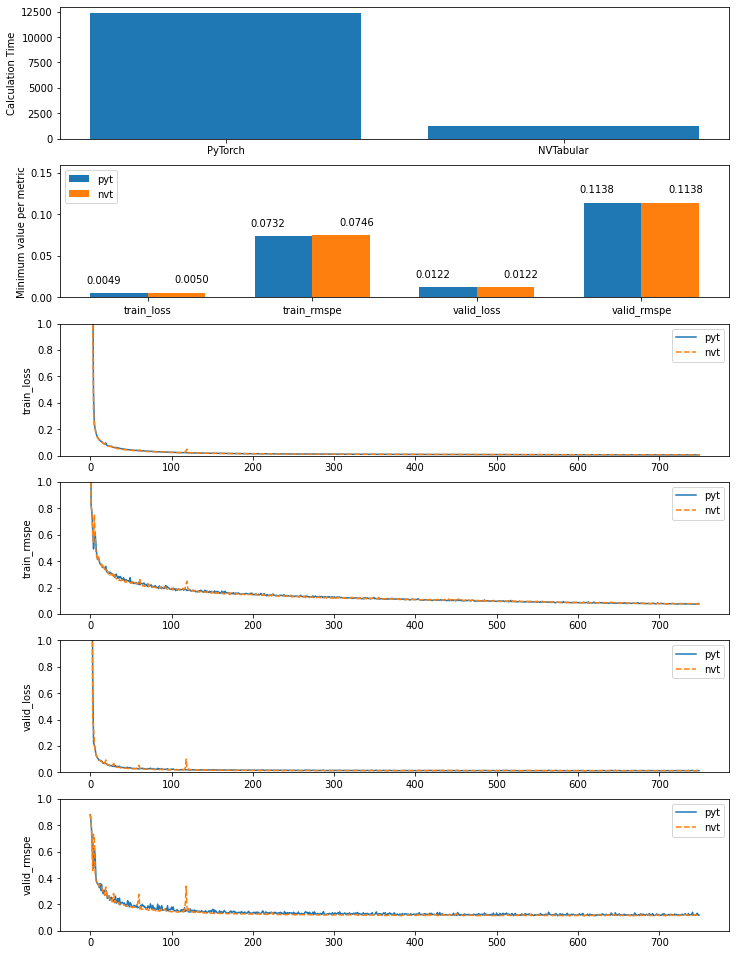

In [15]:
keys = [x for x in pd_pyt.columns if x not in ['epoch']]
keys_ylim = {'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1)}
width = 0.35

fig, ax = plt.subplots(2+len(keys), 1, figsize=(12,17))

# Runtime
ax[0].bar(x=['PyTorch', 'NVTabular'], height=[pyt_dl_runtime, nvt_dl_runtime])
ax[0].set_ylabel('Calculation Time')

# Min Convergence
nvt_min = [pd_nvt[key].min() for key in keys]
pyt_min = [pd_pyt[key].min() for key in keys]
x = np.asarray(list(range(len(keys))))

ax[1].bar(x - width/2, pyt_min, width, label='pyt')
ax[1].bar(x + width/2, nvt_min, width, label='nvt')
ax[1].set_xticks(x)
ax[1].set_xticklabels(keys)
ax[1].set_ylabel('Minimum value per metric')

for x, y in enumerate(pyt_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x - width/1.3,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

for x, y in enumerate(nvt_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x + width/1.3,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

ax[1].set_ylim(0, max(nvt_min+pyt_min)*1.4)
ax[1].legend()

# Convergence
for i in range(len(keys)):
    ax[i+2].plot(pd_pyt[keys[i]], '-', label='pyt')
    ax[i+2].plot(pd_nvt[keys[i]], '--', label='nvt')
    ax[i+2].legend()
    ax[i+2].set_ylabel(keys[i])
    ax[i+2].set_ylim(0,1)

The plots show us following behavior:

1. The native PyTorch data loader requires **~3.47h** (~ 12500) vs. the NVTabular data loader **~ 20min**, which is a **speed-up of ~ 10x**.
2. Both data loaders convergece to the **same minimum in all 4 metrices**. The NVTabular data loader is slightly higher in the train metric, but it is not significant.
3. The plots over time show that **both data loader have similar convergence**. Occasionally, the NVTabular data loaders have spikes for single epochs, but the overall convergence is close to the native PyTorch data loader. 

Similar, we can look on the relative difference between both data loader.

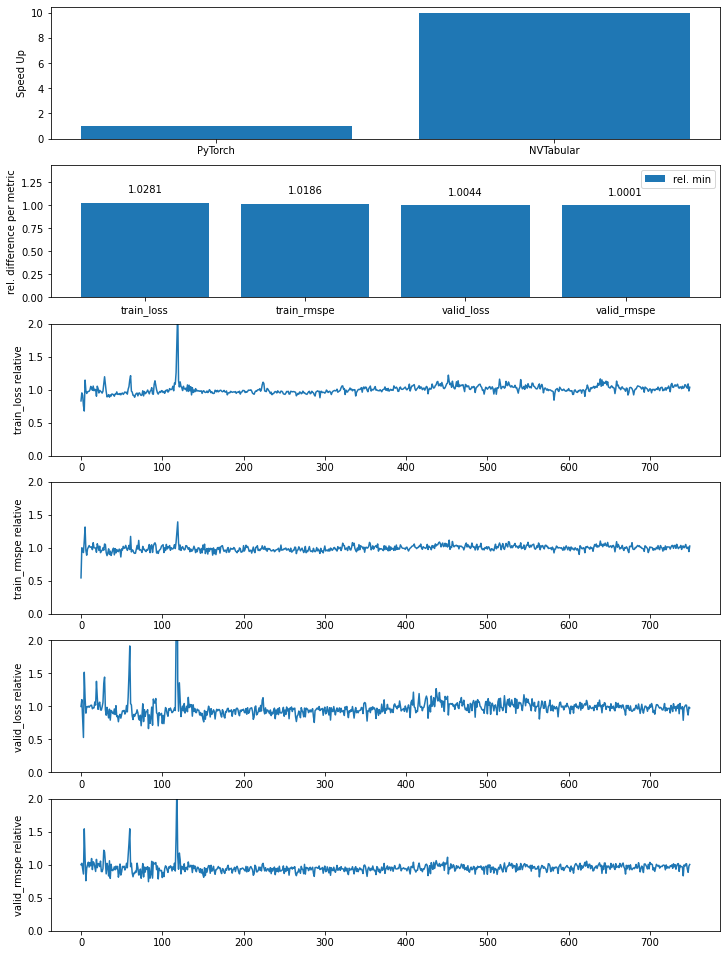

In [16]:
keys = [x for x in pd_pyt.columns if x not in ['epoch']]
keys_ylim = {'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1), 'train_loss': (0,1)}

fig, ax = plt.subplots(2+len(keys), 1, figsize=(12,17))

# Runtime
ax[0].bar(x=['PyTorch', 'NVTabular'], height=[pyt_dl_runtime/pyt_dl_runtime, pyt_dl_runtime/nvt_dl_runtime])
ax[0].set_ylabel('Speed Up')

# Min Convergence
rel_min = [pd_nvt[key].min()/pd_pyt[key].min() for key in keys]
x = np.asarray(list(range(len(keys))))

ax[1].bar(x, rel_min, label='rel. min')
ax[1].set_xticks(x)
ax[1].set_xticklabels(keys)
ax[1].set_ylabel('rel. difference per metric')

for x, y in enumerate(rel_min):
    ax[1].annotate("{:.4f}".format(y), 
                     (x,y),
                     textcoords="offset points",
                     xytext=(0,10),
                     ha='center')

ax[1].set_ylim(0, max(rel_min)*1.4)
ax[1].legend()

# Convergence
for i in range(len(keys)):
    y_values = pd_nvt[keys[i]].values/pd_pyt[keys[i]].values
    ax[i+2].plot(y_values)
    ax[i+2].set_ylabel(keys[i] + ' ' + 'relative')
    ax[i+2].set_ylim(0,2)
    
    #for x, y in enumerate(y_values.tolist()):
    #    ax[i+2].annotate("{:.2f}".format(y)pyt_min, 
    #                     (x,y),
    #                     textcoords="offset points",
    #                     xytext=(0,10),
    #                     ha='center')    

The plots show us following behavior:

1. NVTabular data loader has a **10x speed up**.
2. The relative difference for the performance metric is between **0.01% - 2%**. The validation RMSPE (main metric) has a rel. difference of only 0.01%.
3. The convergence plots per epoch show that there is no relative difference.